[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ietheredge/ASAB-2019-MLWS/blob/master/1-SupervisedLearning-MLWS-ASAB2019-MPIAB.ipynb)

In [ ]:
!git clone https://www.github.com/ietheredge/ASAB-2019-MLWS.git
!{sys.executable} -m pip install --upgrade numpy
!{sys.executable} -m pip install --upgrade scipy
!{sys.executable} -m pip install --upgrade umap
!{sys.executable} -m pip install --upgrade pandas
!{sys.executable} -m pip install --upgrade scikit-learn
!{sys.executable} -m pip install --upgrade tensorflow
!{sys.executable} -m pip install --upgrade keras
!{sys.executable} -m pip install --upgrade scikit-learn

In [3]:
from IPython.display import Image
from keras.optimizers import Adam
import numpy as np
from keras.utils import to_categorical
from sklearn import preprocessing

from content.ASAB-2019-MLWS.utils import evenly_subsample_features, PlotLosses, build_hourglass_model, build_basic_lstm_model, build_conv_lstm_model, build_conv_lstm_2d_model

In [4]:
DATA_DIR = './ASAB-2019-MLWS/data/'
tracking_data_file = os.path.join(DATA_DIR, 'ocellatus_tracked_features.npy')
labels_file = os.path.join(DATA_DIR, 'ocellatus_labels.npy')
tracked_features = np.load(tracking_data_file)
labels = np.load(labels_file)
# inception_features = np.load('data/ocellatus_inception_features.npy')

In [5]:
tracked_features.shape

(40620, 32)

(40620, 32)

In [6]:
labels.shape

(40620, 4)

(40620, 4)

In [7]:
inception_features.shape

(40620, 2048)

(40620, 2048)

In [8]:
labels = (labels > 0.5).astype(np.int_)  # make labels onehot
_, idx, counts = np.unique(labels, axis=0, return_inverse=True, return_counts=True)
labels = to_categorical(idx)
print(labels.shape, tracked_features.shape)

(40620, 4) (40620, 32)
(40620, 4) (40620, 32)


In [9]:
# # be aware of the biases of your data
# these can completely undermine your training
_, idx, counts = np.unique(labels, axis=0, return_inverse=True, return_counts=True)
print(_, counts)

[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]] [30837   732  8131   920]
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]] [30837   732  8131   920]


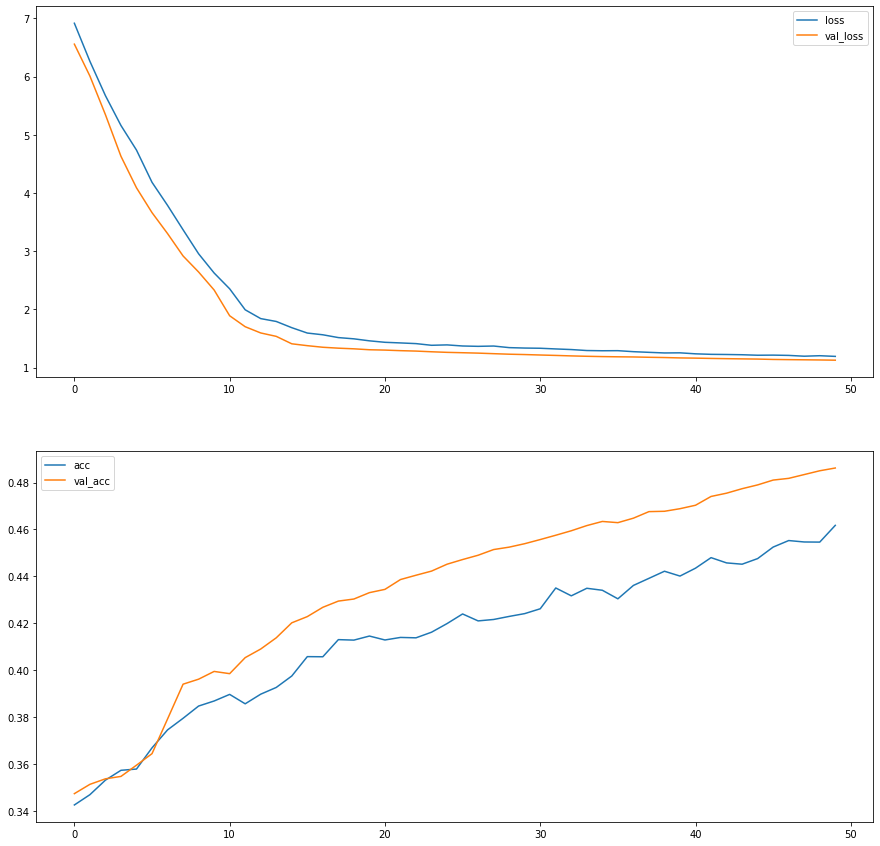

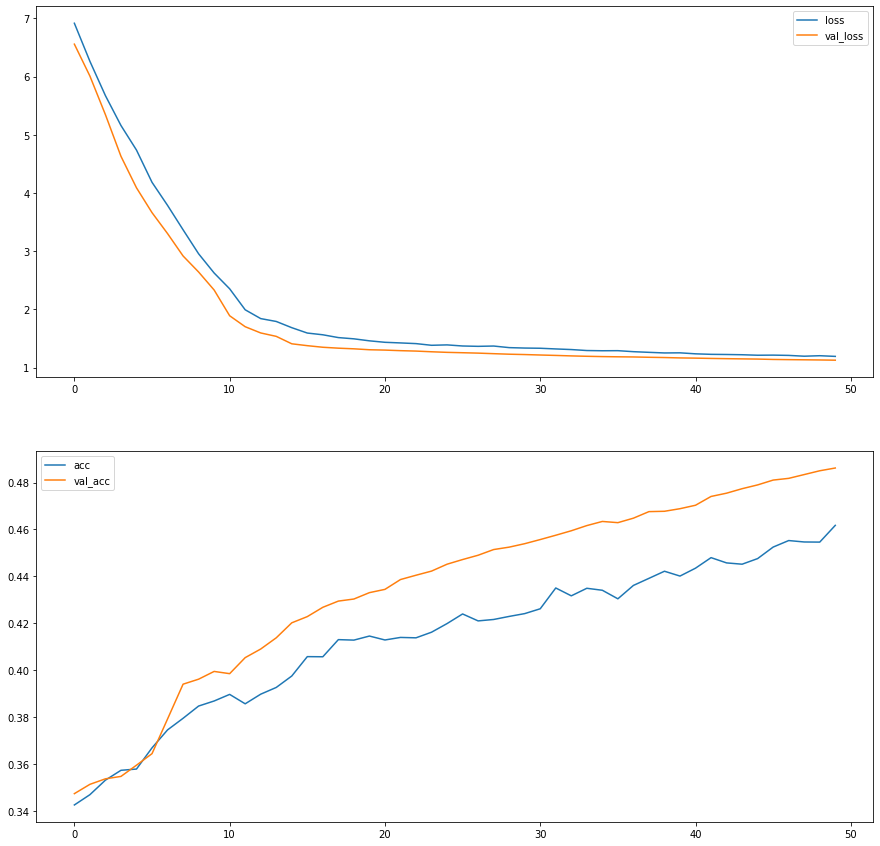

In [10]:
### data
features = preprocessing.scale(tracked_features)

seq_len = 24

X_train, Y_train = evenly_subsample_features(
    labels,
    features,
    idx,
    counts,
    seq_stps=0,  #seq_stps not used in the hourglass model
    seq_len=seq_len,
    n_features=features.shape[1],
)

### model parameters
conv_filter_size=128
conv_kernel_size=1
n_pooling_upsampling_steps=1
n_stacks = 2

hourglass_model = build_hourglass_model(
    input_shape=(
        X_train.shape[1],
        X_train.shape[2]),
    conv_filter_size=conv_filter_size,
    conv_kernel_size=conv_kernel_size,
    n_pooling_upsampling_steps=n_pooling_upsampling_steps,
    n_stacks=n_stacks,
    n_classes=Y_train.shape[2])

loss = 'categorical_crossentropy'
optimizer = Adam(lr=1e-5)
metrics = ['accuracy']

hourglass_model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=metrics) 

hourglass_model.summary()

### training
batch_size = 64
validation_split = 0.2
n_epochs = 50

# loss ploting function
plot_losses = PlotLosses()

# fit
hourglass_model.fit(
    X_train,
    Y_train,
    validation_split=validation_split,
    batch_size=batch_size,
    epochs=n_epochs,
    shuffle=True,
    callbacks=[plot_losses],
    verbose=0
            )

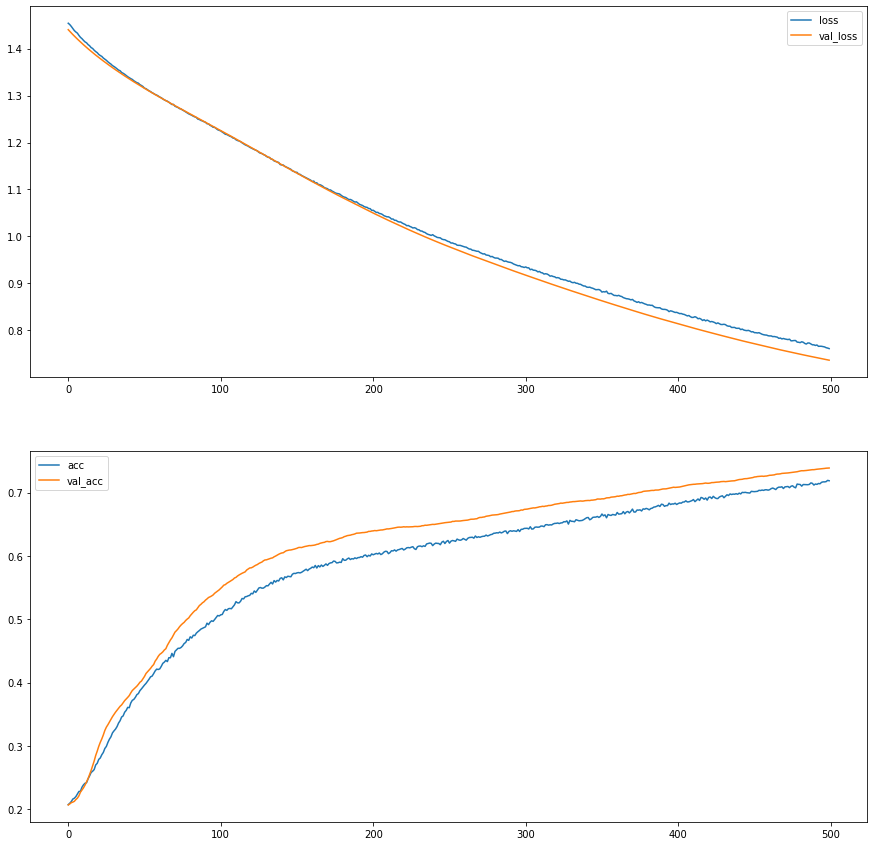

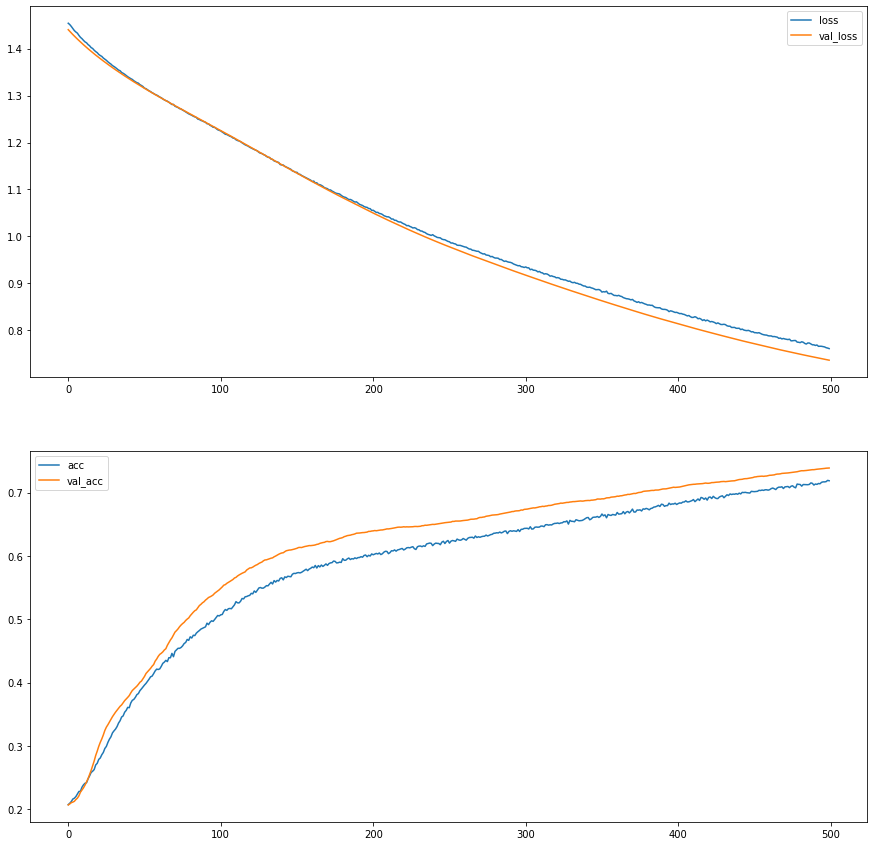

In [11]:
### data
features = preprocessing.scale(tracked_features)

seq_len = 24

X_train, Y_train = evenly_subsample_features(
    labels,
    features,
    idx,
    counts,
    seq_stps=0,  #seq_stps not used in the basic lstm_model
    seq_len=seq_len,
    n_features=features.shape[1],
)

### model parameters
lstm_filters=32
dropout=0.5
use_bidirectional = False

basic_lstm_model = build_basic_lstm_model(
    input_shape=(X_train.shape[1], X_train.shape[2]),
    nb_classes=Y_train.shape[2],
    lstm_filters=lstm_filters,
    dropout=dropout,
    use_bidirectional=use_bidirectional,
)

loss = 'categorical_crossentropy'
optimizer = Adam(lr=1e-5)
metrics = ['accuracy']

basic_lstm_model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=metrics)

basic_lstm_model.summary()

### training
batch_size = 64
validation_split = 0.2
n_epochs = 500

# loss ploting function
plot_losses = PlotLosses()

# fit
basic_lstm_model.fit(
    X_train,
    Y_train,
    validation_split=validation_split,
    batch_size=batch_size,
    epochs=n_epochs,
    shuffle=True,
    callbacks=[plot_losses],
    verbose=0
            )

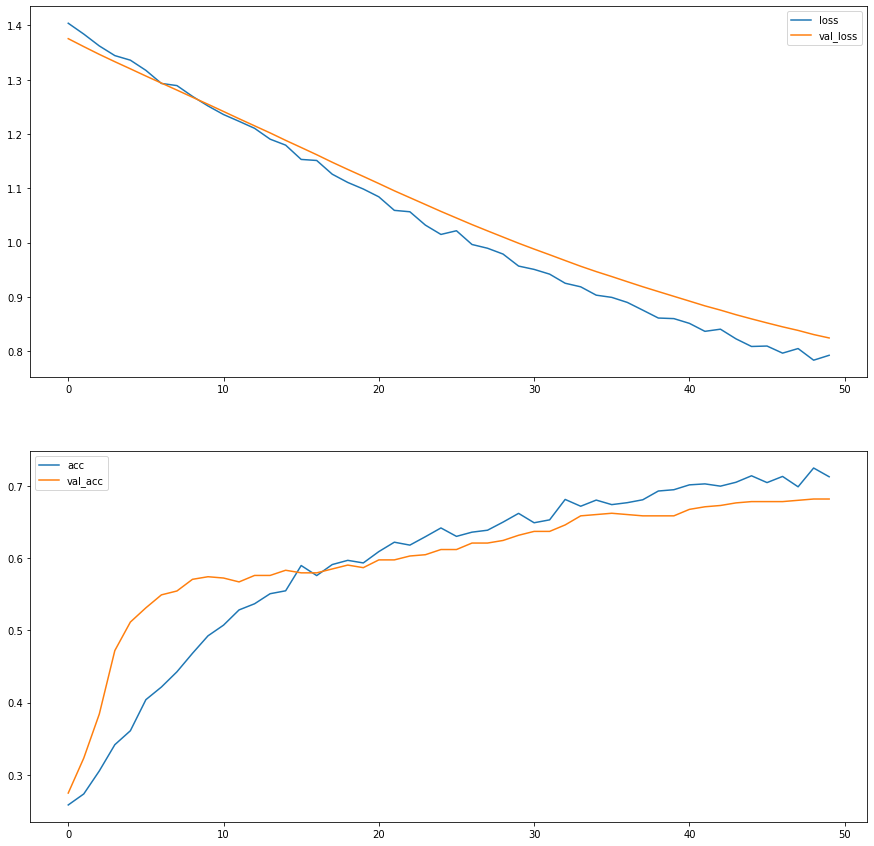

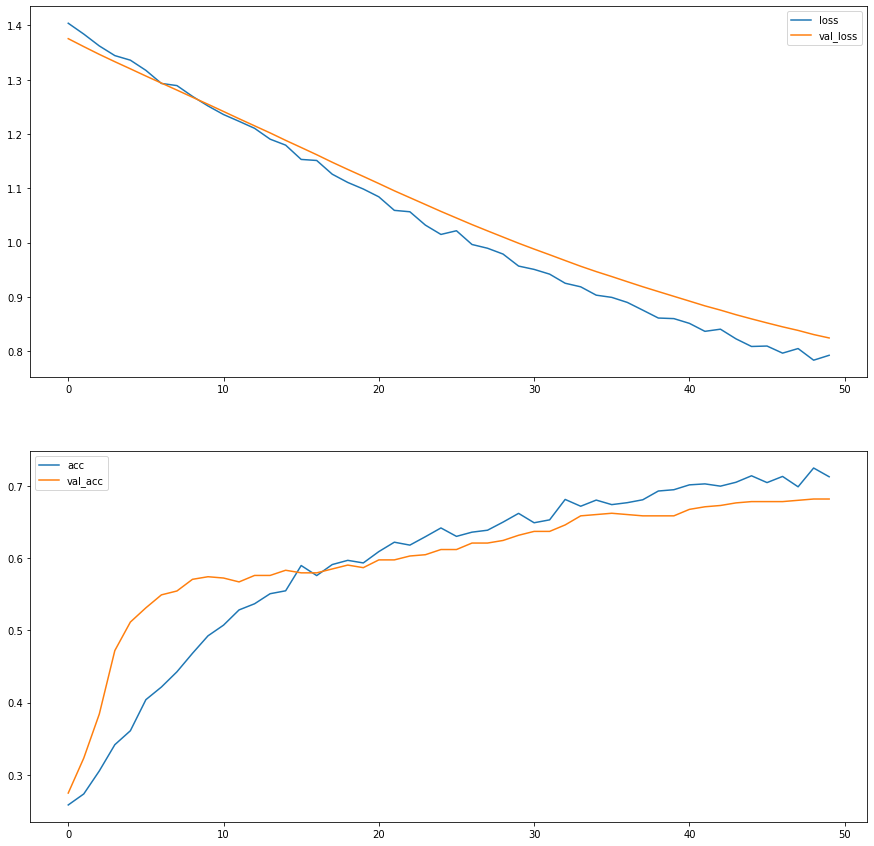

In [12]:
### data
features = preprocessing.scale(tracked_features)

seq_len = 36 
seq_stps = 6

X_train, Y_train = evenly_subsample_features(
    labels,
    features,
    idx,
    counts,
    seq_stps=seq_stps,
    seq_len=seq_len,
    n_features=features.shape[1],
)

print(X_train.shape)

### model
pool_size=2
conv_filters=64
conv_kernel_size=1
lstm_filters=100
dropout=0.5

conv_lstm_model = build_conv_lstm_model(
    input_shape=(
        X_train.shape[1],
        X_train.shape[2],
        X_train.shape[3]),
    pool_size=pool_size,
    conv_filters=conv_filters,
    conv_kernel_size=conv_kernel_size,
    lstm_filters=lstm_filters,
    dropout=dropout,
    nb_classes=Y_train.shape[1],
)

loss = 'categorical_crossentropy'
optimizer = Adam(lr=1e-5)
metrics = ['accuracy']

conv_lstm_model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=metrics)

conv_lstm_model.summary()

### training
batch_size = 64
validation_split = 0.2
n_epochs = 50

# loss ploting function
plot_losses = PlotLosses()

# fit
conv_lstm_model.fit(
    X_train, Y_train,
    validation_split=validation_split,
    batch_size=batch_size,
    epochs=n_epochs,
    shuffle=True,
    callbacks=[plot_losses],
    verbose=0
            )

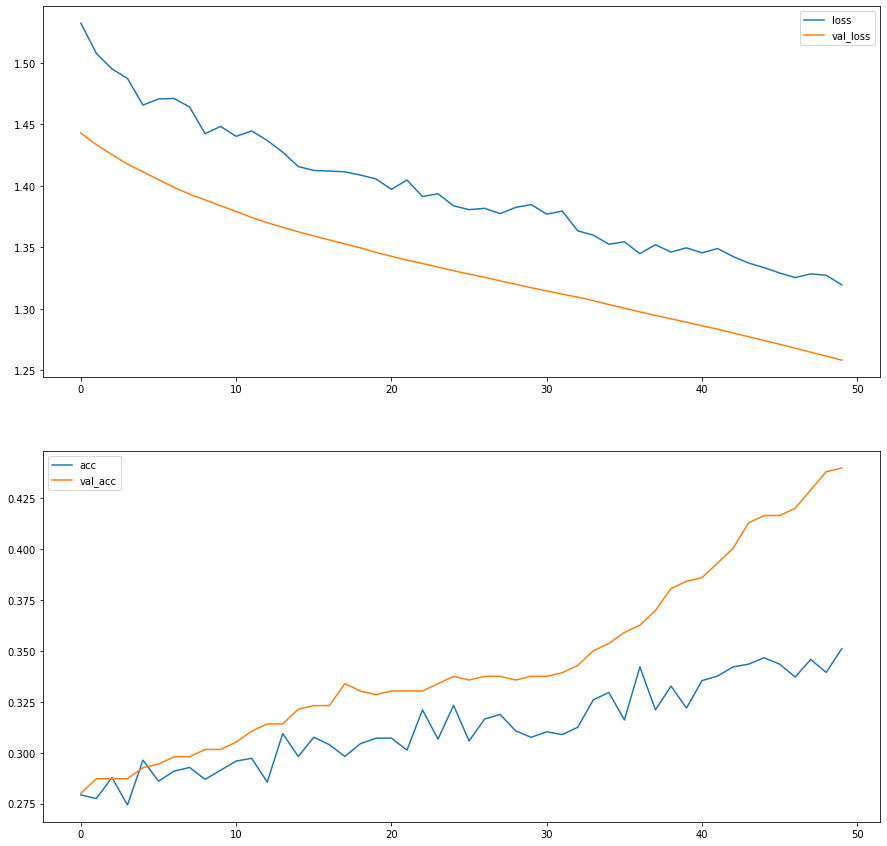

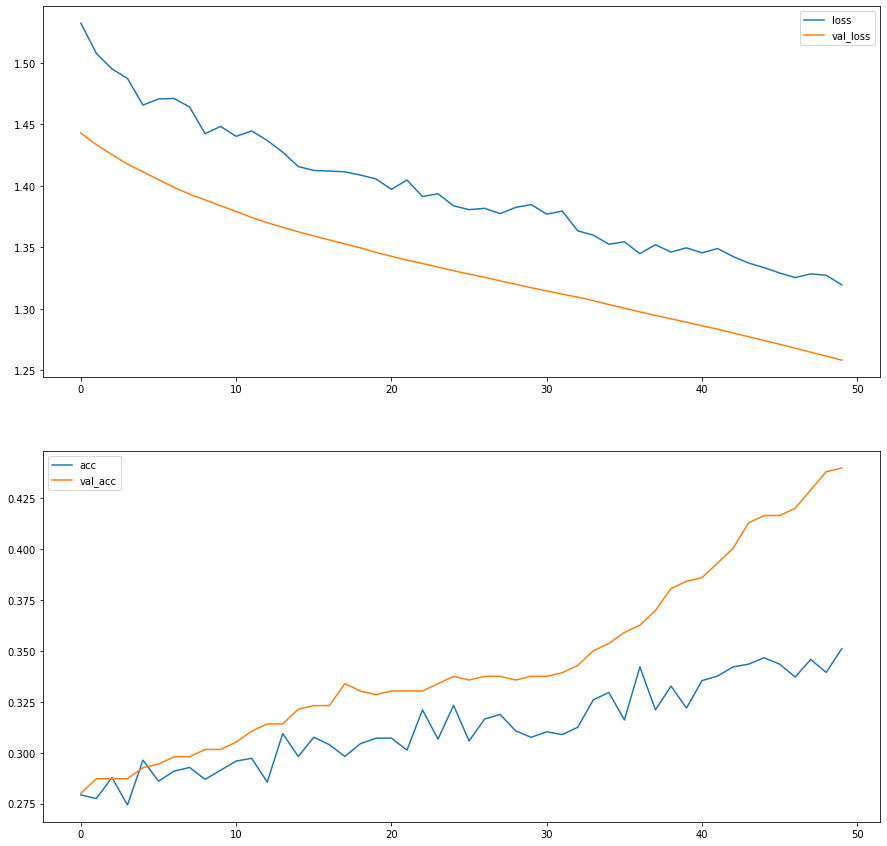

In [13]:
### data
features = preprocessing.scale(tracked_features)

seq_len = 36
seq_stps = 6

X_train, Y_train = evenly_subsample_features(
    labels,
    features,
    idx,
    counts,
    seq_stps=seq_stps,
    seq_len=seq_len,
    n_features=features.shape[1],
)
X_train = X_train.reshape(
    (X_train.shape[0], X_train.shape[1], 1, X_train.shape[2], X_train.shape[3])
)

### model
conv_filters=8
conv_kernel_size=(1,5)
lstm_filters=20
dropout=0.5

conv_lstm_2d_model = build_conv_lstm_2d_model(
    input_shape=(
        X_train.shape[1],
        1,
        X_train.shape[3],
        X_train.shape[4]),
    conv_filters=conv_filters,
    conv_kernel_size=conv_kernel_size,
    lstm_filters=lstm_filters,
    dropout=dropout,
    nb_classes=Y_train.shape[1],
)

loss = 'categorical_crossentropy'
optimizer = Adam(lr=1e-5)
metrics = ['accuracy']

conv_lstm_2d_model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=metrics)

conv_lstm_2d_model.summary()

### training
batch_size = 64
validation_split = 0.2
n_epochs = 50

# loss ploting function
plot_losses = PlotLosses()

# fit
conv_lstm_2d_model.fit(
    X_train, Y_train,
    validation_split=validation_split,
    batch_size=batch_size,
    epochs=n_epochs,
    shuffle=True,
    callbacks=[plot_losses],
    verbose=0
            )

In [14]:
# video_frames = glob.glob('data/raw/ocellatus_video_frames/*.jpg')
# Image(filename=video_frames[np.random.randint(0, len(video_frames)-1)])

NameError: name 'glob' is not defined

NameError: name 'glob' is not defined

In [ ]:
# ### data
# features = inception_features
# # features = preprocessing.scale(tracked_features)

# seq_len = 64 
# seq_stps = 8

# X_train, Y_train = evenly_subsample_features(
#     labels,
#     features,
#     idx,
#     counts,
#     seq_stps=seq_stps,
#     seq_len=seq_len,
#     n_features=features.shape[1],
# )
# X_train = X_train.reshape(
#     (X_train.shape[0], X_train.shape[1], 1, X_train.shape[2], X_train.shape[3])
# )

# ### model
# conv_filters=8
# conv_kernel_size=(1,5)
# lstm_filters=10
# dropout=0.9

# conv_lstm_2d_model = build_conv_lstm_2d_model(
#     input_shape=(
#         X_train.shape[1],
#         1,
#         X_train.shape[3],
#         X_train.shape[4]),
#     conv_filters=conv_filters,
#     conv_kernel_size=conv_kernel_size,
#     lstm_filters=lstm_filters,
#     dropout=dropout,
#     nb_classes=Y_train.shape[1],
# )

# loss = 'categorical_crossentropy'
# optimizer = Adam(lr=1e-5)
# metrics = ['accuracy']

# conv_lstm_2d_model.compile(
#     loss=loss,
#     optimizer=optimizer,
#     metrics=metrics)

# conv_lstm_2d_model.summary()

# ### training
# batch_size = 64
# validation_split = 0.2
# n_epochs = 50

# # loss ploting function
# plot_losses = PlotLosses()

# # fit
# conv_lstm_2d_model.fit(
#     X_train, Y_train,
#     validation_split=validation_split,
#     batch_size=batch_size,
#     epochs=n_epochs,
#     shuffle=True,
#     callbacks=[plot_losses],
#     verbose=0
#             )